### Random Forest Notebook

This Notebook is to model the random forest regression to predict the incidence value in Switzerland and Swiss regions.

In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import json
from datetime import datetime

### Some Data Preparation

In [62]:
# start modelling here
pop_data = pd.read_csv('../data/pop_data_cantons/weekly_imputed_pop_data_final_region.csv')
flu_data = pd.read_csv('../data/INFLUENZA_sentinella/data.csv')
weather_data = pd.read_csv('../data/weather/reg_weather.csv')
google_flu_data = pd.read_csv('../data/google_search_trend/reg_google_grippe.csv')
google_symptoms_data = pd.read_csv('../data/google_search_trend/reg_google_fieber_husten.csv')

In [63]:
# Create dataframe for country-level observations, no differentiation between sex or age
flu_CH = flu_data.query('georegion_type == "country" and agegroup == "all" and sex == "all"').copy()

# Create dataframe for regional observations, no differentiation between sex or age
flu_reg = flu_data.query('georegion_type == "sentinella_region" and agegroup == "all" and sex == "all"').copy()

# Drop unknown region entries from flu_region using mask
flu_reg = flu_reg[~(flu_reg['georegion'] == 'unknown')]

# Select columns required for analysis
selected_cols = ['temporal', 'georegion', 'popExtrapolation', 'incValue']
flu_reg = flu_reg[selected_cols]
flu_reg.rename(columns={'popExtrapolation':'flu_cases'}, inplace=True)

In [64]:
# Align time-indexes of google data and flu data
with open('date_dict.json', 'r') as f:
    date_dict = json.load(f)

google_flu_data['Woche'] = google_flu_data['Woche'].apply(lambda x: date_dict[x])
google_symptoms_data['Woche'] = google_symptoms_data['Woche'].apply(lambda x: date_dict[x])

In [65]:
dates = weather_data.date.values
# Convert dates to 'YYYY-Www' ISO week format
iso_week_dates = [datetime.strptime(date, '%Y-%m-%d').isocalendar()[:2] for date in dates]
iso_week_dates = [f'{year}-W{week:02d}' for year, week in iso_week_dates]
weather_data['date'] = iso_week_dates

In [66]:
# Reshape google_flu from wide to long
google_flu_data = google_flu_data.melt(id_vars=['Woche'], var_name='region_query', value_name='search_activity')

# Separate region and query information from header into separate rows
google_flu_data['region'] = google_flu_data['region_query'].apply(lambda x: "_".join(x.split('_')[:2]))
google_flu_data['query'] = google_flu_data['region_query'].apply(lambda x: "_".join(x.split('_')[2:]))
google_flu_data.drop(columns='region_query', inplace=True) # Drop superfluous region_query column

# Reshape dataframe to get separate columns for each variable
google_flu_data = google_flu_data.pivot(index=['Woche', 'region'], columns='query', values='search_activity').reset_index()

In [67]:
# Reshape google_flu from wide to long
google_symptoms_data = google_symptoms_data.melt(id_vars=['Woche'], var_name='region_query', value_name='search_activity')

# Separate region and query information from header into separate rows
google_symptoms_data['region'] = google_symptoms_data['region_query'].apply(lambda x: "_".join(x.split('_')[:2]))
google_symptoms_data['query'] = google_symptoms_data['region_query'].apply(lambda x: "_".join(x.split('_')[2:]))
google_symptoms_data.drop(columns='region_query', inplace=True) # Drop superfluous region_query column

# Reshape dataframe to get separate columns for each variable
google_symptoms_data = google_symptoms_data.pivot(index=['Woche', 'region'], columns='query', values='search_activity').reset_index()

In [68]:
merged_data = pd.merge(flu_reg, weather_data, how='left', left_on=['temporal', 'georegion'], right_on=['date', 'region']).sort_values(by=['georegion', 'temporal'])
merged_google = pd.merge(google_flu_data, google_symptoms_data, how='inner', on=['region', 'Woche'])
merged_data = pd.merge(merged_data, merged_google, how='left', left_on=['georegion', 'temporal'], right_on=['region', 'Woche'])

In [69]:
merged_data

,temporal,georegion,flu_cases,incValue,region_x,date,weighted_avg_daily_temp,weighted_avg_daily_hum,weighted_max_daily_temp,weighted_min_daily_temp,weighted_max_daily_hum,weighted_min_daily_hum,Woche,region_y,Flu,Flu_resid,Flu_seasonal,Flu_trend,Grippe,Grippe_resid,Grippe_seasonal,Grippe_trend,Influenza,Influenza_resid,Influenza_seasonal,Influenza_trend,influenza,influenza_resid,influenza_seasonal,influenza_trend,Fieber,Fieber_resid,Fieber_seasonal,Fieber_trend,fièvre,fièvre_resid,fièvre_seasonal,fièvre_trend,husten,husten_resid,husten_seasonal,husten_trend,toux,toux_resid,toux_seasonal,toux_trend
0,2013-W01,region_1,16876.1,53.33,region_1,2013-W01,3.044123,82.918337,6.597668,-1.041057,95.043840,63.721907,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-W02,region_1,33045.6,114.99,region_1,2013-W02,1.899121,85.732108,4.005557,-0.232400,94.972297,74.365709,2013-W02,region_1,6.694163,-1.180241,-2.182889,10.057294,13.364971,0.507812,5.565260,7.291899,12.730951,0.035270,4.986369,7.709312,0.000000,-0.266457,-4.918594,5.185051,14.012359,-2.413512,3.443423,12.982448,25.224384,-2.570827,7.554113,20.241099,3.724624,-6.176678,2.571313,7.329989,30.496017,2.831515,13.093592,14.570910
2,2013-W03,region_1,37204.9,185.46,region_1,2013-W03,-1.508554,77.031993,0.870462,-4.233867,90.875307,63.741066,2013-W03,region_1,15.731896,2.856978,2.868328,10.006590,8.495091,0.808069,0.435401,7.251621,16.742543,-0.024616,9.084647,7.682512,0.000000,-2.191639,-3.071684,5.263323,31.712181,4.514063,14.247842,12.950276,15.337335,0.254120,-5.079976,20.163192,7.977211,3.287695,-2.697615,7.387131,10.827069,-0.599317,-3.118453,14.544839
3,2013-W04,region_1,36421.1,307.51,region_1,2013-W04,-0.759157,77.826791,2.469204,-4.891194,90.988158,60.461963,2013-W04,region_1,12.886953,0.545618,2.385324,9.956011,13.066783,1.211959,4.643270,7.211554,18.003596,0.563415,9.784405,7.655776,11.763678,6.478843,-0.056714,5.341549,14.719024,1.562238,0.238883,12.917902,13.586975,-3.277945,-3.220311,20.085231,16.034321,3.831175,4.759199,7.443947,20.094055,-1.412146,6.987013,14.519188
4,2013-W05,region_1,39004.7,502.50,region_1,2013-W05,4.551592,78.802057,7.993836,0.627968,92.950733,58.114673,2013-W05,region_1,20.251145,0.132748,10.212838,9.905558,11.777776,0.883827,3.722246,7.171703,16.342096,0.109972,8.603017,7.629107,0.000000,-0.579764,-4.839965,5.419729,10.902479,-2.175490,0.192648,12.885322,31.616718,3.240345,8.369157,20.007216,3.797554,-6.717551,3.014675,7.500430,11.163364,-1.808321,-1.522283,14.493968
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3403,2023-W42,region_6,14349.7,48.78,region_6,2023-W42,8.779691,86.279860,112.068950,15.165819,16.738540,17.896114,2023-W42,region_6,0.000000,-8.418317,3.801028,4.617289,4.557310,-5.055933,2.571402,7.041841,15.830161,10.048946,-1.631333,7.412548,4.567539,0.843819,-2.860805,6.584525,0.000000,-3.507947,-11.320733,14.828679,0.000000,0.000000,0.000000,0.000000,14.808454,7.342648,-4.320877,11.786683,0.000000,-0.022954,-0.426565,0.449520
3404,2023-W43,region_6,13789.4,116.03,region_6,2023-W43,8.713151,90.941844,146.785800,14.580323,16.035777,6.764381,2023-W43,region_6,0.000000,-0.012139,-4.621183,4.633322,6.165772,-4.893040,3.998443,7.060370,8.287688,1.947735,-1.066951,7.406904,9.447745,-1.144149,4.021414,6.570481,15.541432,2.531880,-1.895107,14.904660,0.000000,0.000000,0.000000,0.000000,5.925534,-0.478980,-5.410189,11.814702,0.000000,-0.171670,-0.269120,0.440791
3405,2023-W44,region_6,9232.8,54.15,region_6,2023-W44,5.359404,93.029671,113.603722,11.504548,19.159654,16.889149,2023-W44,region_6,0.000000,0.016777,-4.666138,4.649361,12.063468,2.570481,2.414204,7.078782,5.715134,-0.174347,-1.511699,7.401180,2.569241,-1.372037,-2.614902,6.556180,13.187346,2.998214,-4.791817,14.980949,0.000000,0.000000,0.000000,0.000000,

In [70]:
pop_data

,region,Jahr-Woche,Bevölkerung 1. Januar,Geburten,Todesfälle,Überschuss,Wanderungssaldo international 1,Wanderungssaldo interkantonal,Bevölkerung 31. Dezember,total,% over Year,Canton Size (km²),Alter 0–19,Alter 20–64,Alter 65 und mehr,Mann,Frau,Schweizer,Ausländer,Ledig,Verheiratet,Verwitwet,Geschieden,Unverheiratet,In eingetragener Partnerschaft,Aufgelöste Partnerschaft,Städtischer Kernraum,Einflussgebiet Stadt,Ausserhalb des Einflusses städtischer Kerne,BIP in Millionen CHF,BIP Growth Laufende Preise,BIP Growth Preise Vorjahr,BIP pro Kopf,Woche,Bevölkerung,% over week,Pop Density
0,CH,2013-W01,8039060,1591.0,1249.0,342.0,1675.0,0.0,8139631,1934.0,1.251029,41285,1633081.0,4990935.0,1415044.0,3972395.0,4066665.0,6125552.0,1913508.0,3494124.0,3484339.0,402630.0,644545.0,521.0,12024.0,877.0,5043379.0,1745310.0,1250371.0,654611.66897,1.70375,1.79214,80422.769653,1,8.039060e+06,NaN,194.721085
1,CH,2013-W02,8039060,1591.0,1249.0,342.0,1675.0,0.0,8139631,1934.0,1.251029,41285,1633481.0,4992159.0,1415391.0,3973370.0,4067662.0,6127054.0,1913978.0,3494982.0,3485194.0,402729.0,644703.0,522.0,12027.0,877.0,5044616.0,1745738.0,1250678.0,654611.66897,1.70375,1.79214,80422.769653,2,8.041032e+06,0.024530,194.768850
2,CH,2013-W03,8039060,1591.0,1249.0,342.0,1675.0,0.0,8139631,1934.0,1.251029,41285,1633882.0,4993383.0,1415739.0,3974344.0,4068660.0,6128557.0,1914447.0,3495839.0,3486048.0,402828.0,644861.0,522.0,12029.0,877.0,5045853.0,1746166.0,1250985.0,654611.66897,1.70375,1.79214,80422.769653,3,8.043004e+06,0.024524,194.816615
3,CH,2013-W04,8039060,1591.0,1249.0,342.0,1675.0,0.0,8139631,1934.0,1.251029,41285,1634282.0,4994608.0,1416086.0,3975318.0,4069657.0,6130059.0,1914917.0,3496696.0,3486903.0,402926.0,645019.0,522.0,12032.0,878.0,5047090.0,1746594.0,1251292.0,654611.66897,1.70375,1.79214,80422.769653,4,8.044976e+06,0.024518,194.864380
4,CH,2013-W05,8039060,1591.0,1249.0,342.0,1675.0,0.0,8139631,1934.0,1.251029,41285,1634683.0,4995832.0,1416433.0,3976293.0,4070655.0,6131562.0,1915386.0,3497553.0,3487758.0,403025.0,645177.0,522.0,12035.0,878.0,5048327.0,1747022.0,1251598.0,654611.66897,1.70375,1.79214,80422.769653,5,8.046948e+06,0.024512,194.912145
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3649,region_6,2022-W48,553557,79.0,106.0,-28.0,87.0,2.0,556561,57.0,0.550028,9917,97501.0,329265.0,129560.0,273981.0,282345.0,417106.0,139219.0,240104.0,233029.0,32080.0,50368.0,58.0,546.0,134.0,318194.0,101541.0,136591.0,0.00000,NaN,NaN,NaN,48,5.563254e+05,0.010732,77.169713
3650,region_6,2022-W49,553557,79.0,106.0,-28.0,87.0,2.0,556561,57.0,0.550028,9917,97511.0,329299.0,129573.0,274010.0,282374.0,417150.0,139235.0,240130.0,233054.0,32083.0,50373.0,58.0,546.0,134.0,318228.0,101551.0,136605.0,0.00000,NaN,NaN,NaN,49,5.563843e+05,0.010730,77.177739
3651,region_6,2022-W50,553557,79.0,106.0,-28.0,87.0,2.0,556561,57.0,0.550028,9917,97521.0,329334.0,129588.0,274039.0,282404.0,417194.0,139249.0,240155.0,233078.0,32088.0,50378.0,58.0,546.0,134.0,318261.0,101561.0,136621.0,0.00000,NaN,NaN,NaN,50,5.564432e+05,0.010729,77.185764
3652,region_6,2022-W51,553557,79.0,106.0,-28.0,87.0,2.0,556561,57.0,0.550028,9917,97532.0,329369.0,129601.0,274068.0,282434.0,417239.0,139264.0,240180.0,233103.0,32091.0,50384.0,58.0,546.0,134.0,318294.0,101572.0,136635.0,0.00000,NaN,NaN,NaN,51,5.565021e+05,0.010728,77.193790


In [71]:
merged_data = pd.merge(merged_data, pop_data, how='left', left_on=['georegion', 'temporal'], right_on=['region', 'Jahr-Woche'])
merged_data

,temporal,georegion,flu_cases,incValue,region_x,date,weighted_avg_daily_temp,weighted_avg_daily_hum,weighted_max_daily_temp,weighted_min_daily_temp,weighted_max_daily_hum,weighted_min_daily_hum,Woche_x,region_y,Flu,Flu_resid,Flu_seasonal,Flu_trend,Grippe,Grippe_resid,Grippe_seasonal,Grippe_trend,Influenza,Influenza_resid,Influenza_seasonal,Influenza_trend,influenza,influenza_resid,influenza_seasonal,influenza_trend,Fieber,Fieber_resid,Fieber_seasonal,Fieber_trend,fièvre,fièvre_resid,fièvre_seasonal,fièvre_trend,husten,husten_resid,husten_seasonal,husten_trend,toux,toux_resid,toux_seasonal,toux_trend,region,Jahr-Woche,Bevölkerung 1. Januar,Geburten,Todesfälle,Überschuss,Wanderungssaldo international 1,Wanderungssaldo interkantonal,Bevölkerung 31. Dezember,total,% over Year,Canton Size (km²),Alter 0–19,Alter 20–64,Alter 65 und mehr,Mann,Frau,Schweizer,Ausländer,Ledig,Verheiratet,Verwitwet,Geschieden,Unverheiratet,In eingetragener Partnerschaft,Aufgelöste Partnerschaft,Städtischer Kernraum,Einflussgebiet Stadt,Ausserhalb des Einflusses städtischer Kerne,BIP in Millionen CHF,BIP Growth Laufende Preise,BIP Growth Preise Vorjahr,BIP pro Kopf,Woche_y,Bevölkerung,% over week,Pop Density
0,2013-W01,region_1,16876.1,53.33,region_1,2013-W01,3.044123,82.918337,6.597668,-1.041057,95.043840,63.721907,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,region_1,2013-W01,1693743.0,351.0,249.0,103.0,565.0,-68.0,1722219.0,549.0,1.527933,9520.0,365930.0,1042917.0,284897.0,827791.0,865952.0,1150475.0,543268.0,751566.0,712209.0,81724.0,145117.0,141.0,2784.0,202.0,1148298.0,371174.0,174271.0,134909.54871,0.532745,0.486882,78683.84215,1.0,1.693743e+06,NaN,537.516672
1,2013-W02,region_1,33045.6,114.99,region_1,2013-W02,1.899121,85.732108,4.005557,-0.232400,94.972297,74.365709,2013-W02,region_1,6.694163,-1.180241,-2.182889,10.057294,13.364971,0.507812,5.565260,7.291899,12.730951,0.035270,4.986369,7.709312,0.000000,-0.266457,-4.918594,5.185051,14.012359,-2.413512,3.443423,12.982448,25.224384,-2.570827,7.554113,20.241099,3.724624,-6.176678,2.571313,7.329989,30.496017,2.831515,13.093592,14.570910,region_1,2013-W02,1693743.0,351.0,249.0,103.0,565.0,-68.0,1722219.0,549.0,1.527933,9520.0,366050.0,1043260.0,284991.0,828064.0,866237.0,1150855.0,543446.0,751814.0,712444.0,81751.0,145164.0,142.0,2785.0,202.0,1148670.0,371301.0,174331.0,134909.54871,0.532745,0.486882,78683.84215,2.0,1.694301e+06,0.029959,537.665907
2,2013-W03,region_1,37204.9,185.46,region_1,2013-W03,-1.508554,77.031993,0.870462,-4.233867,90.875307,63.741066,2013-W03,region_1,15.731896,2.856978,2.868328,10.006590,8.495091,0.808069,0.435401,7.251621,16.742543,-0.024616,9.084647,7.682512,0.000000,-2.191639,-3.071684,5.263323,31.712181,4.514063,14.247842,12.950276,15.337335,0.254120,-5.079976,20.163192,7.977211,3.287695,-2.697615,7.387131,10.827069,-0.599317,-3.118453,14.544839,region_1,2013-W03,1693743.0,351.0,249.0,103.0,565.0,-68.0,1722219.0,549.0,1.527933,9520.0,366172.0,1043604.0,285083.0,828336.0,866522.0,1151234.0,543625.0,752062.0,712678.0,81778.0,145211.0,142.0,2786.0,202.0,1149040.0,371429.0,174392.0,134909.54871,0.532745,0.486882,78683.84215,3.0,1.694860e+06,0.029950,537.815142
3,2013-W04,region_1,36421.1,307.51,region_1,2013-W04,-0.759157,77.826791,2.469204,-4.891194,90.988158,60.461963,2013-W04,region_1,12.886953,0.545618,2.385324,9.956011,13.066783,1.211959,4.643270,7.211554,18.003596,0.563415,9.784405,7.655776,11.763678,6.478843,-0.056714,5.341549,14.719024,1.562238,0.238883,12.917902,13.586975,-3.277945,-3.220311,20.085231,16.034321,3.831175,4.759199,7.443947,20.094055,-1.412146,6.987013,14.519188,region_1,2013-W04,1693743.0,351.0,249.0,103.0,565.0,-68.0,1722219.0,549.0,1.527933,9520.0,366293.0,1043949.0,285178.0,828611.0,866809.0,1151614.0,543804.0,752310.0,712915.0,81805.0,145258.0,142.0,2786.0,202.0,1149412.0,371555.0,174451.0,134909.54871,0.532745,0.486882,78683.84215,4.0,1.695418e+06,0.029941,53

In [72]:
merged_data.columns

Index(['temporal', 'georegion', 'flu_cases', 'incValue', 'region_x', 'date',
       'weighted_avg_daily_temp', 'weighted_avg_daily_hum',
       'weighted_max_daily_temp', 'weighted_min_daily_temp',
       'weighted_max_daily_hum', 'weighted_min_daily_hum', 'Woche_x',
       'region_y', 'Flu', 'Flu_resid', 'Flu_seasonal', 'Flu_trend', 'Grippe',
       'Grippe_resid', 'Grippe_seasonal', 'Grippe_trend', 'Influenza',
       'Influenza_resid', 'Influenza_seasonal', 'Influenza_trend', 'influenza',
       'influenza_resid', 'influenza_seasonal', 'influenza_trend', 'Fieber',
       'Fieber_resid', 'Fieber_seasonal', 'Fieber_trend', 'fièvre',
       'fièvre_resid', 'fièvre_seasonal', 'fièvre_trend', 'husten',
       'husten_resid', 'husten_seasonal', 'husten_trend', 'toux', 'toux_resid',
       'toux_seasonal', 'toux_trend', 'region', 'Jahr-Woche',
       'Bevölkerung 1. Januar', 'Geburten', 'Todesfälle', 'Überschuss',
       'Wanderungssaldo international 1', 'Wanderungssaldo interkantonal',
 

In [73]:
merged_data.drop(columns=['region_x', 'region_y', 'date', 'Woche_x', 'Woche_y', 'Jahr-Woche', 'Bevölkerung 31. Dezember'], inplace=True)

In [74]:
import datetime

# Functions taken from: https://stackoverflow.com/questions/304256/whats-the-best-way-to-find-the-inverse-of-datetime-isocalendar
def iso_year_start(iso_year):
    "The gregorian calendar date of the first day of the given ISO year"
    fourth_jan = datetime.date(iso_year, 1, 4)
    delta = datetime.timedelta(fourth_jan.isoweekday()-1)
    return fourth_jan - delta 

def iso_to_gregorian(iso_year, iso_week, iso_day):
    "Gregorian calendar date for the given ISO year, week and day"
    year_start = iso_year_start(iso_year)
    return year_start + datetime.timedelta(days=iso_day-1, weeks=iso_week-1)


In [75]:
# Define the regex pattern
pattern = r'W(\d{1,2})'

# Extract week number and year and convert to integer
merged_data['week_number'] = merged_data['temporal'].str.extract(pattern).astype(int)

merged_data['year'] = merged_data['temporal'].apply(lambda x: x.split('-')[0])
merged_data['year'] = pd.to_numeric(merged_data['year'])

# Convert from iso-calendar week to dates
merged_data['date'] = list(map(lambda year, week: iso_to_gregorian(year, week, 4), merged_data['year'], merged_data['week_number']))

In [76]:
merged_data.set_index('date', inplace=True)

In [77]:
# Impute missing values in March 2020 linearly
merged_data['incValue'].interpolate(inplace=True)

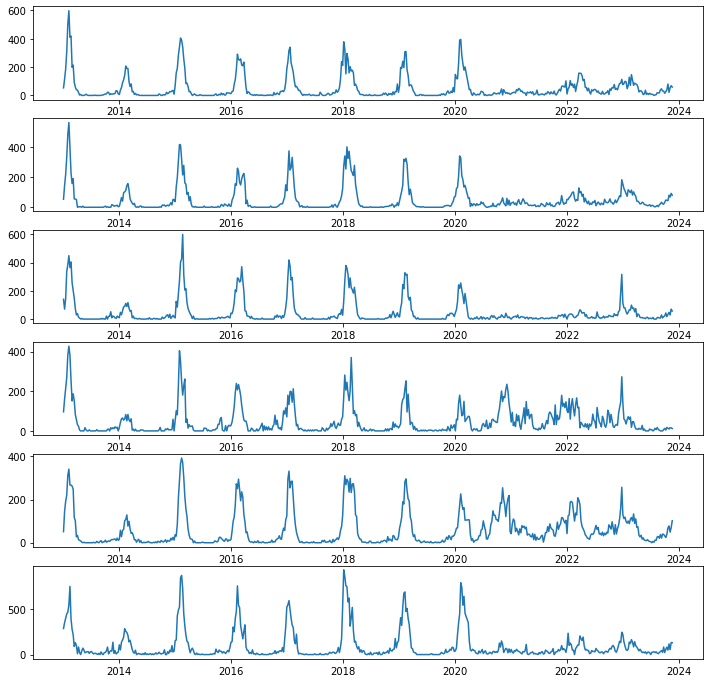

In [78]:
fig, ax = plt.subplots(6, figsize=(12, 12))
for i in range(1, 7):
    ax[i-1].plot(merged_data.loc[merged_data['georegion'] == f"region_{i}", 'incValue'])

### Some Feature Engineering

In [79]:
def create_lagged_features(df, column, number_of_lags=4):
    # Group by 'georegion' and apply the lagging within each group
    new_df = df.groupby('georegion', group_keys=False).apply(lambda group: group.assign(
        **{f'lag_{i}': group[column].shift(i) for i in range(1, number_of_lags + 1)}
    ))

    # Reset index to flatten the dataframe structure after grouping
    new_df.reset_index(drop=True, inplace=True)

    return new_df

# Create lagged features
df_lagged = create_lagged_features(merged_data, column='flu_cases', number_of_lags=10)

# Drop rows with NaN values (due to lagging)
df_lagged.dropna(inplace=True)

In [80]:
pd.set_option('display.max_columns', None) # den ganzen dataframe anzeigen
# zum resetten: pd.reset_option('display.max_columns')
df_lagged.sort_values(by=['georegion', 'temporal'], inplace=True)
df_lagged

,temporal,georegion,flu_cases,incValue,weighted_avg_daily_temp,weighted_avg_daily_hum,weighted_max_daily_temp,weighted_min_daily_temp,weighted_max_daily_hum,weighted_min_daily_hum,Flu,Flu_resid,Flu_seasonal,Flu_trend,Grippe,Grippe_resid,Grippe_seasonal,Grippe_trend,Influenza,Influenza_resid,Influenza_seasonal,Influenza_trend,influenza,influenza_resid,influenza_seasonal,influenza_trend,Fieber,Fieber_resid,Fieber_seasonal,Fieber_trend,fièvre,fièvre_resid,fièvre_seasonal,fièvre_trend,husten,husten_resid,husten_seasonal,husten_trend,toux,toux_resid,toux_seasonal,toux_trend,region,Bevölkerung 1. Januar,Geburten,Todesfälle,Überschuss,Wanderungssaldo international 1,Wanderungssaldo interkantonal,total,% over Year,Canton Size (km²),Alter 0–19,Alter 20–64,Alter 65 und mehr,Mann,Frau,Schweizer,Ausländer,Ledig,Verheiratet,Verwitwet,Geschieden,Unverheiratet,In eingetragener Partnerschaft,Aufgelöste Partnerschaft,Städtischer Kernraum,Einflussgebiet Stadt,Ausserhalb des Einflusses städtischer Kerne,BIP in Millionen CHF,BIP Growth Laufende Preise,BIP Growth Preise Vorjahr,BIP pro Kopf,Bevölkerung,% over week,Pop Density,week_number,year,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10
10,2013-W11,region_1,35830.0,92.10,3.041126,64.027594,7.018732,-0.632312,81.997623,43.954862,0.000000,-3.368578,-6.236864,9.605442,5.974433,-0.234542,-0.728203,6.937178,5.512320,-0.503105,-1.455183,7.470608,0.000000,1.094892,-6.982402,5.887510,21.917020,-6.417936,15.649629,12.685326,23.734216,2.802974,1.393514,19.537728,13.778820,-4.187536,10.134365,7.831990,15.636673,0.554132,0.730203,14.352338,region_1,1693743.0,351.0,249.0,103.0,565.0,-68.0,549.0,1.527933,9520.0,367141.0,1046356.0,285830.0,830522.0,868805.0,1154271.0,545057.0,754047.0,714561.0,81992.0,145589.0,142.0,2794.0,203.0,1152012.0,372445.0,174870.0,134909.54871,0.532745,0.486882,78683.842150,1.699327e+06,0.029874,539.009022,11,2013,33656.1,34254.9,32491.9,36076.5,40782.5,39004.7,36421.1,37204.9,33045.6,16876.1
11,2013-W12,region_1,36919.6,59.59,5.351498,71.945642,9.155251,1.765799,90.831871,50.519858,0.000000,0.461160,-10.017010,9.555850,6.050227,0.592131,-1.440751,6.898847,6.823323,0.313165,-0.934306,7.444465,0.000000,-3.048210,-2.917035,5.965245,15.536895,1.550778,1.334822,12.651295,0.000000,-6.972005,-12.487074,19.459079,0.000000,-8.290872,0.404888,7.885984,36.556094,26.811151,-4.585442,14.330385,region_1,1693743.0,351.0,249.0,103.0,565.0,-68.0,549.0,1.527933,9520.0,367261.0,1046700.0,285924.0,830794.0,869090.0,1154651.0,545235.0,754295.0,714796.0,82018.0,145636.0,142.0,2795.0,203.0,1152383.0,372571.0,174931.0,134909.54871,0.532745,0.486882,78683.842150,1.699885e+06,0.029865,539.158257,12,2013,35830.0,33656.1,34254.9,32491.9,36076.5,40782.5,39004.7,36421.1,37204.9,33045.6
12,2013-W13,region_1,29930.4,40.09,3.761392,81.351220,6.519214,1.699399,91.306503,67.184987,10.042775,1.329320,-0.792926,9.506382,6.439333,-2.256139,1.834742,6.860730,7.543991,-0.580933,0.706517,7.418407,29.952801,28.930119,-5.020224,6.042906,15.778674,0.803612,2.357954,12.617107,14.760214,-0.122306,-4.497723,19.380243,1.995334,-5.712603,-0.231647,7.939585,22.102943,-0.080205,7.874250,14.308899,region_1,1693743.0,351.0,249.0,103.0,565.0,-68.0,549.0,1.527933,9520.0,367383.0,1047043.0,286018.0,831068.0,869376.0,1155029.0,545414.0,754542.0,715031.0,82045.0,145684.0,142.0,2796.0,203.0,1152755.0,372698.0,174991.0,134909.54871,0.532745,0.486882,78683.842150,1.700443e+06,0.029856,539.307492,13,2013,36919.6,35830.0,33656.1,34254.9,32491.9,36076.5,40782.5,39004.7,36421.1,37204.9
13,2013-W14,region_1,23935.8,37.60,5.961335,67.501318,10.141658,2.485400,84.755874,48.880789,2.648978,-0.005569,-6.802492,9.457039,5.186546,-0.153933,-1.482348,6.822827,6.879237,0.660645,-1.173846,7.392439,33.381886,42.791256,-15.529859,6.120489,12.369131,-3.370064,3.156406,12.582789,18.287678,2.967924,-3.981443,19.301197,3.458579,-1.579628,-2.954583,7.992791,14.963228,4.980870,-4.305520,14.287878,region_1,1693743.0,351.0,249.0,103.0,565.0,-68.0,549.0,

In [81]:
df_lagged['BIP letztes Jahr'] = df_lagged.groupby(['region', 'year'])['BIP in Millionen CHF'].shift(-1)
df_lagged['BIP vorletztes Jahr'] = df_lagged.groupby(['region', 'year'])['BIP in Millionen CHF'].shift(-2)
df_lagged['BIP Growth letztes Jahr laufende Preise'] = df_lagged.groupby(['region', 'year'])['BIP Growth Laufende Preise'].shift(-1)
df_lagged['BIP Growth vorletztes Jahr laufende Preise'] = df_lagged.groupby(['region', 'year'])['BIP Growth Laufende Preise'].shift(-2)
df_lagged['BIP Growth letztes Jahr Preise Vorjahr'] = df_lagged.groupby(['region', 'year'])['BIP Growth Preise Vorjahr'].shift(-1)
df_lagged['BIP Growth vorletztes Jahr Preise Vorjahr'] = df_lagged.groupby(['region', 'year'])['BIP Growth Preise Vorjahr'].shift(-2)

In [82]:
df_lagged.drop(columns=['BIP in Millionen CHF', 'BIP Growth Laufende Preise', 'BIP Growth Preise Vorjahr'], inplace=True)

In [83]:
# Optional: Umwandlung in tatsächliche Datumswerte (erster Tag der Woche)
df_lagged['Datum'] = pd.to_datetime(df_lagged['year'].astype(str) + df_lagged['week_number'].astype(str) + '1', format='%Y%W%w')


In [84]:
df_lagged

,temporal,georegion,flu_cases,incValue,weighted_avg_daily_temp,weighted_avg_daily_hum,weighted_max_daily_temp,weighted_min_daily_temp,weighted_max_daily_hum,weighted_min_daily_hum,Flu,Flu_resid,Flu_seasonal,Flu_trend,Grippe,Grippe_resid,Grippe_seasonal,Grippe_trend,Influenza,Influenza_resid,Influenza_seasonal,Influenza_trend,influenza,influenza_resid,influenza_seasonal,influenza_trend,Fieber,Fieber_resid,Fieber_seasonal,Fieber_trend,fièvre,fièvre_resid,fièvre_seasonal,fièvre_trend,husten,husten_resid,husten_seasonal,husten_trend,toux,toux_resid,toux_seasonal,toux_trend,region,Bevölkerung 1. Januar,Geburten,Todesfälle,Überschuss,Wanderungssaldo international 1,Wanderungssaldo interkantonal,total,% over Year,Canton Size (km²),Alter 0–19,Alter 20–64,Alter 65 und mehr,Mann,Frau,Schweizer,Ausländer,Ledig,Verheiratet,Verwitwet,Geschieden,Unverheiratet,In eingetragener Partnerschaft,Aufgelöste Partnerschaft,Städtischer Kernraum,Einflussgebiet Stadt,Ausserhalb des Einflusses städtischer Kerne,BIP pro Kopf,Bevölkerung,% over week,Pop Density,week_number,year,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,BIP letztes Jahr,BIP vorletztes Jahr,BIP Growth letztes Jahr laufende Preise,BIP Growth vorletztes Jahr laufende Preise,BIP Growth letztes Jahr Preise Vorjahr,BIP Growth vorletztes Jahr Preise Vorjahr,Datum
10,2013-W11,region_1,35830.0,92.10,3.041126,64.027594,7.018732,-0.632312,81.997623,43.954862,0.000000,-3.368578,-6.236864,9.605442,5.974433,-0.234542,-0.728203,6.937178,5.512320,-0.503105,-1.455183,7.470608,0.000000,1.094892,-6.982402,5.887510,21.917020,-6.417936,15.649629,12.685326,23.734216,2.802974,1.393514,19.537728,13.778820,-4.187536,10.134365,7.831990,15.636673,0.554132,0.730203,14.352338,region_1,1693743.0,351.0,249.0,103.0,565.0,-68.0,549.0,1.527933,9520.0,367141.0,1046356.0,285830.0,830522.0,868805.0,1154271.0,545057.0,754047.0,714561.0,81992.0,145589.0,142.0,2794.0,203.0,1152012.0,372445.0,174870.0,78683.842150,1.699327e+06,0.029874,539.009022,11,2013,33656.1,34254.9,32491.9,36076.5,40782.5,39004.7,36421.1,37204.9,33045.6,16876.1,134909.54871,134909.54871,0.532745,0.532745,0.486882,0.486882,2013-03-18
11,2013-W12,region_1,36919.6,59.59,5.351498,71.945642,9.155251,1.765799,90.831871,50.519858,0.000000,0.461160,-10.017010,9.555850,6.050227,0.592131,-1.440751,6.898847,6.823323,0.313165,-0.934306,7.444465,0.000000,-3.048210,-2.917035,5.965245,15.536895,1.550778,1.334822,12.651295,0.000000,-6.972005,-12.487074,19.459079,0.000000,-8.290872,0.404888,7.885984,36.556094,26.811151,-4.585442,14.330385,region_1,1693743.0,351.0,249.0,103.0,565.0,-68.0,549.0,1.527933,9520.0,367261.0,1046700.0,285924.0,830794.0,869090.0,1154651.0,545235.0,754295.0,714796.0,82018.0,145636.0,142.0,2795.0,203.0,1152383.0,372571.0,174931.0,78683.842150,1.699885e+06,0.029865,539.158257,12,2013,35830.0,33656.1,34254.9,32491.9,36076.5,40782.5,39004.7,36421.1,37204.9,33045.6,134909.54871,134909.54871,0.532745,0.532745,0.486882,0.486882,2013-03-25
12,2013-W13,region_1,29930.4,40.09,3.761392,81.351220,6.519214,1.699399,91.306503,67.184987,10.042775,1.329320,-0.792926,9.506382,6.439333,-2.256139,1.834742,6.860730,7.543991,-0.580933,0.706517,7.418407,29.952801,28.930119,-5.020224,6.042906,15.778674,0.803612,2.357954,12.617107,14.760214,-0.122306,-4.497723,19.380243,1.995334,-5.712603,-0.231647,7.939585,22.102943,-0.080205,7.874250,14.308899,region_1,1693743.0,351.0,249.0,103.0,565.0,-68.0,549.0,1.527933,9520.0,367383.0,1047043.0,286018.0,831068.0,869376.0,1155029.0,545414.0,754542.0,715031.0,82045.0,145684.0,142.0,2796.0,203.0,1152755.0,372698.0,174991.0,78683.842150,1.700443e+06,0.029856,539.307492,13,2013,36919.6,35830.0,33656.1,34254.9,32491.9,36076.5,40782.5,39004.7,36421.1,37204.9,134909.54871,134909.54871,0.532745,0.532745,0.486882,0.486882,2013-04-01
13,2013-W14,region_1,23935.8,37.60,5.961335,67.501318,10.141658,2.485400,84.755874,48.880789,2.648978,-0.005569,-6.802492,9.457039,5.186546,-0.153933,-1.482348,6.822827,6.879237,0.660645,-1.173846,

In [89]:
# dummies aus georegion machen
df_lagged_with_dummies = pd.get_dummies(df_lagged, columns=['georegion'], drop_first=True)
df_lagged_with_dummies

,temporal,flu_cases,incValue,weighted_avg_daily_temp,weighted_avg_daily_hum,weighted_max_daily_temp,weighted_min_daily_temp,weighted_max_daily_hum,weighted_min_daily_hum,Flu,Flu_resid,Flu_seasonal,Flu_trend,Grippe,Grippe_resid,Grippe_seasonal,Grippe_trend,Influenza,Influenza_resid,Influenza_seasonal,Influenza_trend,influenza,influenza_resid,influenza_seasonal,influenza_trend,Fieber,Fieber_resid,Fieber_seasonal,Fieber_trend,fièvre,fièvre_resid,fièvre_seasonal,fièvre_trend,husten,husten_resid,husten_seasonal,husten_trend,toux,toux_resid,toux_seasonal,toux_trend,region,Bevölkerung 1. Januar,Geburten,Todesfälle,Überschuss,Wanderungssaldo international 1,Wanderungssaldo interkantonal,total,% over Year,Canton Size (km²),Alter 0–19,Alter 20–64,Alter 65 und mehr,Mann,Frau,Schweizer,Ausländer,Ledig,Verheiratet,Verwitwet,Geschieden,Unverheiratet,In eingetragener Partnerschaft,Aufgelöste Partnerschaft,Städtischer Kernraum,Einflussgebiet Stadt,Ausserhalb des Einflusses städtischer Kerne,BIP pro Kopf,Bevölkerung,% over week,Pop Density,week_number,year,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,BIP letztes Jahr,BIP vorletztes Jahr,BIP Growth letztes Jahr laufende Preise,BIP Growth vorletztes Jahr laufende Preise,BIP Growth letztes Jahr Preise Vorjahr,BIP Growth vorletztes Jahr Preise Vorjahr,Datum,georegion_region_2,georegion_region_3,georegion_region_4,georegion_region_5,georegion_region_6
10,2013-W11,35830.0,92.10,3.041126,64.027594,7.018732,-0.632312,81.997623,43.954862,0.000000,-3.368578,-6.236864,9.605442,5.974433,-0.234542,-0.728203,6.937178,5.512320,-0.503105,-1.455183,7.470608,0.000000,1.094892,-6.982402,5.887510,21.917020,-6.417936,15.649629,12.685326,23.734216,2.802974,1.393514,19.537728,13.778820,-4.187536,10.134365,7.831990,15.636673,0.554132,0.730203,14.352338,region_1,1693743.0,351.0,249.0,103.0,565.0,-68.0,549.0,1.527933,9520.0,367141.0,1046356.0,285830.0,830522.0,868805.0,1154271.0,545057.0,754047.0,714561.0,81992.0,145589.0,142.0,2794.0,203.0,1152012.0,372445.0,174870.0,78683.842150,1.699327e+06,0.029874,539.009022,11,2013,33656.1,34254.9,32491.9,36076.5,40782.5,39004.7,36421.1,37204.9,33045.6,16876.1,134909.54871,134909.54871,0.532745,0.532745,0.486882,0.486882,2013-03-18,False,False,False,False,False
11,2013-W12,36919.6,59.59,5.351498,71.945642,9.155251,1.765799,90.831871,50.519858,0.000000,0.461160,-10.017010,9.555850,6.050227,0.592131,-1.440751,6.898847,6.823323,0.313165,-0.934306,7.444465,0.000000,-3.048210,-2.917035,5.965245,15.536895,1.550778,1.334822,12.651295,0.000000,-6.972005,-12.487074,19.459079,0.000000,-8.290872,0.404888,7.885984,36.556094,26.811151,-4.585442,14.330385,region_1,1693743.0,351.0,249.0,103.0,565.0,-68.0,549.0,1.527933,9520.0,367261.0,1046700.0,285924.0,830794.0,869090.0,1154651.0,545235.0,754295.0,714796.0,82018.0,145636.0,142.0,2795.0,203.0,1152383.0,372571.0,174931.0,78683.842150,1.699885e+06,0.029865,539.158257,12,2013,35830.0,33656.1,34254.9,32491.9,36076.5,40782.5,39004.7,36421.1,37204.9,33045.6,134909.54871,134909.54871,0.532745,0.532745,0.486882,0.486882,2013-03-25,False,False,False,False,False
12,2013-W13,29930.4,40.09,3.761392,81.351220,6.519214,1.699399,91.306503,67.184987,10.042775,1.329320,-0.792926,9.506382,6.439333,-2.256139,1.834742,6.860730,7.543991,-0.580933,0.706517,7.418407,29.952801,28.930119,-5.020224,6.042906,15.778674,0.803612,2.357954,12.617107,14.760214,-0.122306,-4.497723,19.380243,1.995334,-5.712603,-0.231647,7.939585,22.102943,-0.080205,7.874250,14.308899,region_1,1693743.0,351.0,249.0,103.0,565.0,-68.0,549.0,1.527933,9520.0,367383.0,1047043.0,286018.0,831068.0,869376.0,1155029.0,545414.0,754542.0,715031.0,82045.0,145684.0,142.0,2796.0,203.0,1152755.0,372698.0,174991.0,78683.842150,1.700443e+06,0.029856,539.307492,13,2013,36919.6,35830.0,33656.1,34254.9,32491.9,36076.5,40782.5,39004.7,36421.1,37204.9,134909.54871,134909.54871,0.532745,0.532745,0.486882,0.486882,2013-04-01,False,False,False,False,False
13,2013-W14,23935.8,37.60,5.961335,67.501318,10.1

### Some Modelling YAY

In [93]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np



X = df_lagged_with_dummies.drop(columns=['flu_cases', 'incValue', 'temporal', 'Datum', 'region']).values  # Features
y = df_lagged_with_dummies['incValue'].values  # Target

# Datenaufteilung
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

# Modellerstellung
regressor = DecisionTreeRegressor()

# Training des Modells
regressor.fit(X_train, y_train)

# Vorhersagen auf dem Testset
predictions = regressor.predict(X_test)

# Bewertung des Modells
mse_train = mean_squared_error(y_train, regressor.predict(X_train))
rmse_train = np.sqrt(mse_train)
print(f"RMSE: {rmse_train}")
mse_test = mean_squared_error(y_test, predictions)
rmse_test = np.sqrt(mse_test)
print(f"RMSE: {rmse_test}")

# Weitere Schritte können das Feintunen des Modells und das Experimentieren mit anderen Modellen umfassen.


RMSE: 49.51976509425489
RMSE: 123.78289714494703
